# <center>Instituto Tecnológico de Estudios Superiores de Occidente</center>



<img style="float: center" src="logo-ITESO-png.png" width="350px" height="125px"/>




#### <center>"Simulación Matemática"</center>


### <center>SIMULACIÓN DE UN PORTAFOLIO DE INVERSIÓN</center>

.



**<center>Profesor: Gabriel Alejando Morales Ruiz</center>**

.



**<center>Leonardo Rodríguez Hernández - 741983</center>**



**<center>Valenzuela Lafarga Mariana - 749770</center>**



**<center>Nancy Woolrich Sorroza - 741983</center>**



.


**<center>22 de abril 2024.</center>**

## <center> Construcción de un portafolio de inversión con programación lineal</center>

### Introducción
    
  
    

### Objetivos

#### 1.1 Objetivo general.

Pronosticar un portaforlio de inversión a un año.

#### 1.2 Objetivos específicos

- 


### Modelo del problema.

Para generar el modelo que maximice los rendimientos se utilizarán los datos diarios de los últimos 3 años de los activos sacados de Yahoo finance.

Las acciones con las que se trabajará en el portafolio son:

>- **VRTX:** Vertex Pharmaceuticals Incorporated, una empresa de biotecnología, se dedica al desarrollo y comercialización de terapias para el tratamiento de la fibrosis quística (FQ).


>- **LLY:** Eli Lilly and Company descubre, desarrolla y comercializa productos farmacéuticos humanos en todo el mundo.


>- **FN:** Fabrinet ofrece embalaje óptico y servicios de fabricación óptica, electromecánica y electrónica de precisión en América del Norte, Asia-Pacífico y Europa.


>- **OXY:** Occidental Petroleum Corporation, junto con sus subsidiarias, se dedica a la adquisición, exploración y desarrollo de propiedades de petróleo y gas en los Estados Unidos, Medio Oriente y el norte de África.


>- **ACWI:** El índice MSCI ACWI (All Country World Index) está compuesto por acciones de empresas de todo el mundo, incluyendo tanto mercados desarrollados como emergentes.


>- **RF:** Activo libre de riesgo en este caso se tomo el dato del CETE a 28 días.


In [1]:
import pandas_datareader.data as web
import yfinance as yf
import pandas as pd
import numpy as np
%matplotlib inline
yf.pdr_override()

In [3]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers,
                   start_date=None,
                   end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.get_data_yahoo(
        tickers=tickers,
        start=start_date,
        end=end_date
    )
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [15]:
tickers = ["VRTX", "LLY", "FN", "OXY", "ACWI"]
start_date = start_date = "2021-02-22"
closes = get_adj_closes(
    tickers=tickers,
    start_date=start_date
)
closes.head()

[*********************100%***********************]  5 of 5 completed


,ACWI,FN,LLY,OXY,VRTX
Date,,,,,
2021-02-22 00:00:00-05:00,89.845230,88.720001,193.580917,25.905037,214.960007
2021-02-23 00:00:00-05:00,89.911545,88.120003,195.317230,25.503790,216.440002
2021-02-24 00:00:00-05:00,90.423096,90.160004,197.285065,27.558966,217.039993
2021-02-25 00:00:00-05:00,88.424225,87.889999,196.609848,26.179062,212.979996
2021-02-26 00:00:00-05:00,87.637947,88.330002,197.641998,26.042049,212.550003


.

El siguente paso es obtener el rendimiento diario y anualizarlo.

.

In [16]:
ret = closes.pct_change().dropna()
ret.head()

,ACWI,FN,LLY,OXY,VRTX
Date,,,,,
2021-02-23 00:00:00-05:00,0.000738,-0.006763,0.008969,-0.015489,0.006885
2021-02-24 00:00:00-05:00,0.005689,0.023150,0.010075,0.080583,0.002772
2021-02-25 00:00:00-05:00,-0.022106,-0.025178,-0.003423,-0.050071,-0.018706
2021-02-26 00:00:00-05:00,-0.008892,0.005006,0.005250,-0.005234,-0.002019
2021-03-01 00:00:00-05:00,0.023025,0.037700,0.007712,0.038707,-0.010209


In [17]:
summary_annual = pd.DataFrame({
    "media": ret.mean() * 252,
}).T
summary_annual

,ACWI,FN,LLY,OXY,VRTX
media,0.071197,0.363434,0.500917,0.3883,0.265542


- **Modelo**

Una vez que se obtuvieron los rendimientos anualizados ya se puede generar la función a optimizar que queda de la sieguiente manera:

.

$$\max_{ACWI, \dots ,RF}  0.0711 ACWI + 0.3634 FN + 0.5009 LLY + 0.3883 OXY + 0.265542 VRTX + 0.1123 RF$$

.


Esta función lo que hace es que el rendimiento de cada activo se multiplica por la cantidad de dinero que se invertirá en cada uno y se suman para obtener el rendimiento total que se busca maximizar.

La cantidad de dinero que se coloca en cada acción, son las variables que no se pueden controlar, por lo que serán resueltas por medio de programación lineal.


- **Restricciones**

La principal restricción para este modelo es que la cantidad de dinero  disponible para invertir será de $\$1,000,000$. Por otro lado, para administrar el riesgo se quiere colocar al menos el $35\%$ en el activo libre de riesgo y en cada activo se debe invertir al menos el $10\%$ de la inversión total.

Las restricciones quedarán de la siguiente manera:

1. $ACWI+ FN+ LLY+ OXY + VRTX + RF =1000000$
2. $RF \geq 350,000 $
3. $ ACWI \geq 100,000$
4. $ FN \geq 100,000$
5. $ LLY \geq 100,000$
6. $ OXY \geq 100,000$
7. $ VRTX \geq 100,000$

- **Explicación y limitaciones**

El modelo planteado anteriormente pretende resolver la cantidad de capital que se tiene que invertir en cada uno de los activos para obtener el máximo rendimiento cumpliendo con las restricciones dadas. 

Las limitaciones que presenta este modelo es que no toma en cuenta el riesgo de los activos, ya que se decidió maximizar el rendimiento por encima del riesgo; la otra limitación es que debido a que los rendimientos de cada activo son fluctuantes no van a ser exactos, sin embargo este modelo trata de aproximarse lo más posible con los datos históricos. 

### Solución del modelo

Los pasos a seguir son:

1. Importar las funciones que se van a usar.
2. Declarar las matrices que representan la función de costo y las restricciones.

In [5]:
import numpy as np
import scipy.optimize as opt

c=np.array([-0.7711,
            -0.3634,
            -0.5009,
            -0.3883,
            -0.265542,
            -0.1123])

A_ub=np.array([ 
    [-1, 0, 0, 0, 0, 0],
    [0, -1, 0, 0, 0, 0],
    [0, 0, -1, 0, 0, 0],
    [0, 0, 0, -1, 0, 0],
    [0, 0, 0, 0, -1, 0],
    [0, 0, 0, 0, 0, -1]
])

bub=np.array([-100000,
              -100000,
              -100000,
              -100000,
              -100000,
              -350000,])

A_eq=np.array([ 
    [1, 1, 1, 1, 1, 1]
])

beq=np.array([1000000])

import scipy.optimize as opt

opt.linprog (c, A_ub, bub, A_eq, beq)


        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -383894.2
              x: [ 2.500e+05  1.000e+05  1.000e+05  1.000e+05  1.000e+05
                   3.500e+05]
            nit: 0
          lower:  residual: [ 2.500e+05  1.000e+05  1.000e+05  1.000e+05
                              1.000e+05  3.500e+05]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00  0.000e+00]
          upper:  residual: [       inf        inf        inf        inf
                                    inf        inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00  0.000e+00]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [-7.711e-01]
        ineqlin:  residual: [ 1.500e+05  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00  0.000e+00]
                 margi

Se obtuvo que de los activos **𝐴𝐶𝑊𝐼** se deben invertir **$\$250,000$**; de **𝐹𝑁** se deben invertir **$\$100,000$**; de **𝐿𝐿𝑌** se deben invertir **$\$100,000$**; de **𝑂𝑋𝑌** se deben invertir **$\$100,000$**; de **V𝑅𝑇𝑋** se deben invertir **$\$100,000$**; y de **𝑅𝐹** se deben invertir **$\$350,000$**.

Estos resultados tienen congruencia, al sumar todos los montos que salieron de resultado da los $\$1,000,000$ que se deseaba invertir en todos los activos.

### Visualización gráfica de la solución

En la siguiente gráfica de pastel se muestra el resultado exlicado en la solución del modelo, representando en porcentaje la cantidad de dinero que se va a invertir para cada activo, recordando que la cantidad total es de $\$1,000,000$.

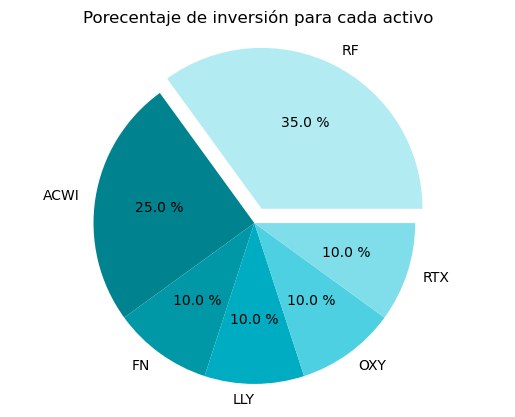

In [1]:
import matplotlib.pyplot as plt

plt.title('Porecentaje de inversión para cada activo')
activos = [350000,250000,100000,100000,100000,100000]
nombres = ["RF","ACWI","FN","LLY","OXY","RTX"]
colores = ["#b2ebf2", "#00838f", "#0097a7", "#00acc1", "#4dd0e1", "#80deea"]
desfase = (0.1, 0, 0, 0, 0, 0)
plt.pie(activos, labels=nombres, autopct="%0.1f %%", colors=colores, explode=desfase)
plt.axis("equal")
plt.show()



### Conclusiones.

Finalmente, se puede concluir que se logró encontrar el portafolio de inversión que maximiza las ganancias de la cartera propuesta con la función de costo, la cual fue planteada con el rendimiento anual de los activos de Vertex Pharmaceuticals Incorporated (VRTX), Eli Lilly and Company (LLY), Fabrinet (FN), Occidental Petroleum Corporation (OXY), el índice MSCI ACWI (All Country World Index) (ACWI) y el activo libre de riesgo (RF). 

Con un capital disponible de $\$1,000,000$ del que se colocó en el activo libre de riesgo al menos el $35\%$ y al menos el $10\%$  en cada activo de la inversión total, la optimización arrojó que se debe invertir $\$250,000$ en 𝐴𝐶𝑊𝐼; $\$100,000$ en 𝐹𝑁, 𝐿𝐿𝑌, 𝑂𝑋𝑌 y V𝑅𝑇𝑋; y $\$350,000$ en 𝑅𝐹 para obtener un rendimiento máximo en la cartera de inversión, el cual es un resultado coherente para este problema.


### Referencias.

>-COPARMEX Jalisco (2022). *¿Qué es un portafolio de inversión financiera?*. Coparmex.org. Recuperado de: https://coparmexjal.org.mx/entorno-empresarial/que-es-un-portafolio-de-inversion-financiera/